# A Look at Demographics in St. Petersburg's City Council District 8

## Setup

### Import packages

In [17]:
import pandas as pd
import geopandas as gpd
import censusdata
import seaborn as sns
import folium
from pathlib import Path
import contextily as ctx

### Find Florida's FIPS number
It's 12. We'll use this number later to filter the data to the state.

In [19]:
states = censusdata.geographies(censusdata.censusgeo([("state", "*")]), "acs5", 2015)
states["Florida"]

censusgeo((('state', '12'),))

### Find Pinellas County's FIPS number
It's 103. We'll use this number later to filter data to the county.

In [20]:
counties = censusdata.geographies(
    censusdata.censusgeo([("state", "12"), ("county", "*")]), "acs5", 2015
)
counties["Pinellas County, Florida"]

censusgeo((('state', '12'), ('county', '103')))

## Work with the 2015 ACS

### Define the variables we want to know about

The code below says to get the data for every census tract in Pinellas and to then store the information about certain variables stored in the 2015 American Community Survey. 

It's totally possible to ask more questions, and you can [get a sense of the range of information available here](https://www.socialexplorer.com/data/ACS2015_5yr/metadata/?ds=ACS15_5yr). I started by asking some basic questions about key percentages:

- Percentage of the population that is white
- Median age of the population


- Race information from [this link](https://www.socialexplorer.com/data/ACS2015_5yr/metadata/?ds=ACS15_5yr&table=B02001).
- Citizenship information from [this link](https://www.socialexplorer.com/data/ACS2015_5yr/metadata/?ds=ACS15_5yr&table=B05001)
- Education information from [this link](https://www.socialexplorer.com/data/ACS2015_5yr/metadata/?ds=ACS15_5yr&table=B15003)

In [29]:
pinellas_acs = censusdata.download(
    "acs5",
    2015,
    censusdata.censusgeo(
        [
            ("state", "12"),
            ("county", "103"),
            ("tract", "*"),
        ]
    ),
    [
        "B25001_001E",  # total housing units
        "B01002_001E",  # Median age - Total
        "B25001_001M",  # margin
        "B02001_001E",  # Total population
        "B02001_002E",  # White Alone
        "B02001_003E",  # Black or African American Alone
        ### citizenship
        "B05001_002E",  # U.s. Citizen, Born in the United States
        "B05001_005E",  # U.s. Citizen by Naturalization"
        "B05001_006E",  # Not a U.s. Citizen"
        "B15003_022E",  # Bachelor's Degree
        "B15003_023E",  # Master's Degree
        "B15003_024E",  # Professional school Degree
        "B15003_025E",  # Doctorate
        ### Benefits
        "B19058_001E",  # total households
        "B19058_002E",  # Receives assistance or SNAP
        ### Percent between 18 and 30
        "B01001_007E",  # male 18 and 19
        "B01001_008E",
        "B01001_009E",
        "B01001_010E",
        "B01001_011E",  # male 25 to 29
        "B01001_032E",  # female 18 and 19
        "B01001_033E",
        "B01001_034E",
        "B01001_035E",  # female 25 to 29
    ],
)

### Narrow data down to District 8 tracts
I have selected seven census tracts that cover most, but not all, of District 8. I got the map of census tracts [from this page](https://www2.census.gov/geo/maps/dc10map/tract/st12_fl/c12103_pinellas/DC10CT_C12103_002.pdf).

In [31]:
pinellas_acs = pinellas_acs.reset_index()

pinellas_acs["tract"] = pinellas_vac["index"].astype(str).str[-6:]
cond = pinellas_vac["tract"].isin(
    ["022801", "022802", "022700", "023000", "022902", "022901", "022601"]
)
district_8 = pinellas_acs[cond].copy()

### Compute a few key features
The data comes to us as a count of people who answer yes to certain questions or who give a certain answer, but that's not quite the form we need them in. The computations below give us useful features like:

- what percent of households are receiving public assistance?
- what percentage of the population is between the ages of 18 and 29?

In [33]:
district_8["percent_white"] = round(
    district_8["B02001_002E"] / district_8["B02001_001E"], 3
)

district_8["median_age_total"] = district_8["B01002_001E"]

district_8["percent_us_born"] = round(
    district_8["B05001_002E"] / district_8["B02001_001E"], 3
)

district_8["percent_college"] = round(
    (
        district_8["B15003_022E"]
        + district_8["B15003_023E"]
        + district_8["B15003_024E"]
        + district_8["B15003_025E"]
    )
    / district_8["B02001_001E"],
    3,
)

district_8["percent_assistance"] = round(
    district_8["B19058_002E"] / district_8["B19058_001E"], 3
)

district_8["percent_18_to_29"] = round(
    (
        district_8["B01001_007E"]
        + district_8["B01001_008E"]
        + district_8["B01001_009E"]
        + district_8["B01001_010E"]
        + district_8["B01001_011E"]
        + district_8["B01001_032E"]
        + district_8["B01001_033E"]
        + district_8["B01001_034E"]
        + district_8["B01001_035E"]
    )
    / district_8["B02001_001E"],
    3,
)

district_8.head(3)

,level_0,index,B25001_001E,B01002_001E,B25001_001M,B02001_001E,B02001_002E,B02001_003E,B05001_002E,B05001_005E,...,B01001_033E,B01001_034E,B01001_035E,tract,percent_white,median_age_total,percent_us_born,percent_college,percent_assistance,percent_18_to_29
33,33,"Census Tract 226.01, Pinellas County, Florida:...",1677,45.3,48,3202,2874,153,2834,222,...,74,41,85,022601,0.898,45.3,0.885,0.164,0.071,0.162
35,35,"Census Tract 227, Pinellas County, Florida: Su...",1936,44.5,66,4247,3474,334,3483,472,...,16,90,164,022700,0.818,44.5,0.820,0.243,0.162,0.156
36,36,"Census Tract 228.01, Pinellas County, Florida:...",2068,37.6,32,4607,3726,430,3613,369,...,40,90,224,022801,0.809,37.6,0.784,0.120,0.213,0.180


## Mapping

In [34]:
district_8['GEOID'] = district_8['tract'].apply(lambda x: '12103' + str(x)) 

Census tract shapefiles obtained from [this link(https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2015&layergroup=Census+Tracts).

In [36]:
shapefile_path = Path.cwd() / "tl_2015_12_tract" / "tl_2015_12_tract.shp"
gdf = gpd.read_file(shapefile_path)[["GEOID", "geometry"]]

cond_dist_8 = gdf['GEOID'].isin(district_8['GEOID'])
gdf[cond_dist_8].head(3)

,GEOID,geometry
1458,12103022601,"POLYGON ((-82.71229 27.79177, -82.71220 27.791..."
1466,12103022700,"POLYGON ((-82.69999 27.78817, -82.70000 27.789..."
1469,12103022802,"POLYGON ((-82.70004 27.79909, -82.69882 27.799..."


In [37]:
merged = gdf.merge(district_8, on='GEOID').set_index("GEOID")
merged = merged.to_crs(epsg=3857)
merged.head(3)

,geometry,level_0,index,B25001_001E,B01002_001E,B25001_001M,B02001_001E,B02001_002E,B02001_003E,B05001_002E,...,B01001_033E,B01001_034E,B01001_035E,tract,percent_white,median_age_total,percent_us_born,percent_college,percent_assistance,percent_18_to_29
GEOID,,,,,,,,,,,,,,,,,,,,,
12103022601,"POLYGON ((-9207489.671 3222746.278, -9207480.5...",33,"Census Tract 226.01, Pinellas County, Florida:...",1677,45.3,48,3202,2874,153,2834,...,74,41,85,022601,0.898,45.3,0.885,0.164,0.071,0.162
12103022700,"POLYGON ((-9206120.887 3222292.525, -9206121.5...",35,"Census Tract 227, Pinellas County, Florida: Su...",1936,44.5,66,4247,3474,334,3483,...,16,90,164,022700,0.818,44.5,0.820,0.243,0.162,0.156
12103022802,"POLYGON ((-9206126.341 3223667.545, -9205990.3...",37,"Census Tract 228.02, Pinellas County, Florida:...",1313,40.3,52,3578,2728,124,2680,...,11,7,127,022802,0.762,40.3,0.749,0.179,0.104,0.138


Text(0.5, 1.0, "Percentage of Residents with a Bachelor's Degree or Higher")

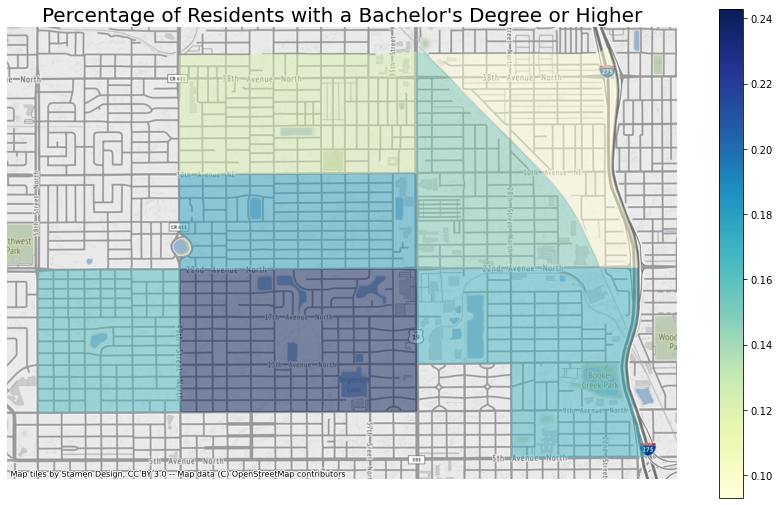

In [39]:
ax = merged.dropna().plot(
    column="percent_college",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis("off")
ax.set_title(
    "Percentage of Residents with a Bachelor's Degree or Higher",
    fontdict={"fontsize": "20", "fontweight": "4"},
)

[Text(0.5, 1.0, 'Percentage of Residents Born in the United States')]

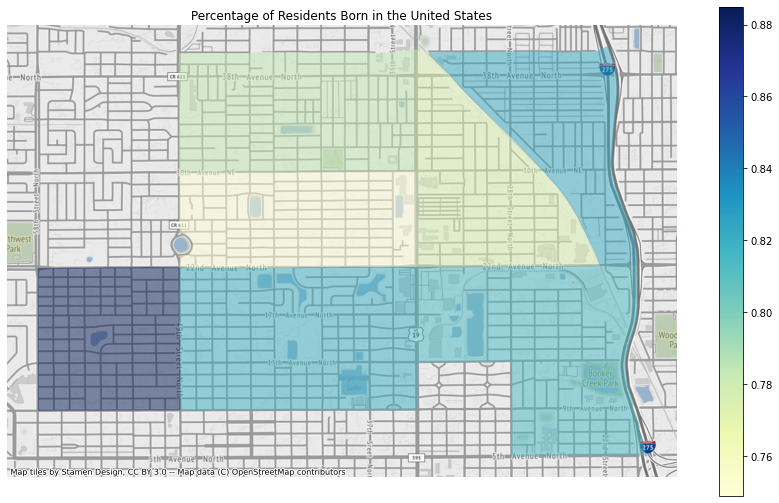

In [12]:
ax = merged.dropna().plot(
    column="percent_us_born",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Percentage of Residents Born in the United States")

[Text(0.5, 1.0, "Percentage of Residents Whose Race Is 'White Alone'")]

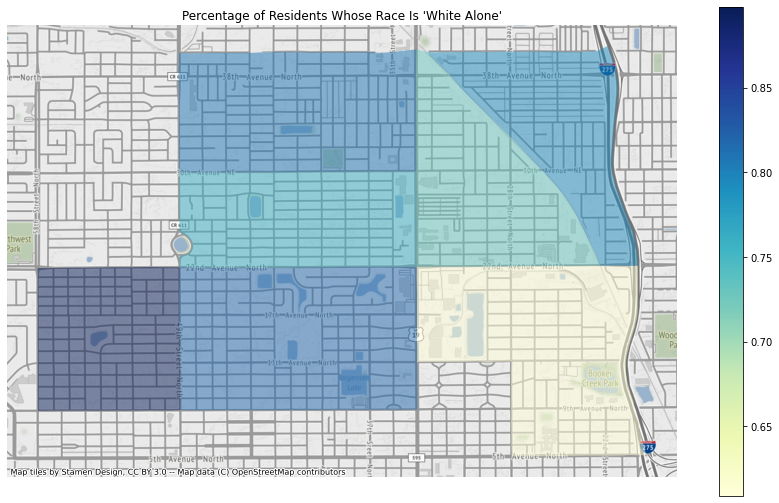

In [13]:
ax = merged.dropna().plot(
    column="percent_white",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Percentage of Residents Whose Race Is 'White Alone'")

[Text(0.5, 1.0, 'Percentage of Households That Got Public Assistance Income or Food Stamps in Past 12 Months')]

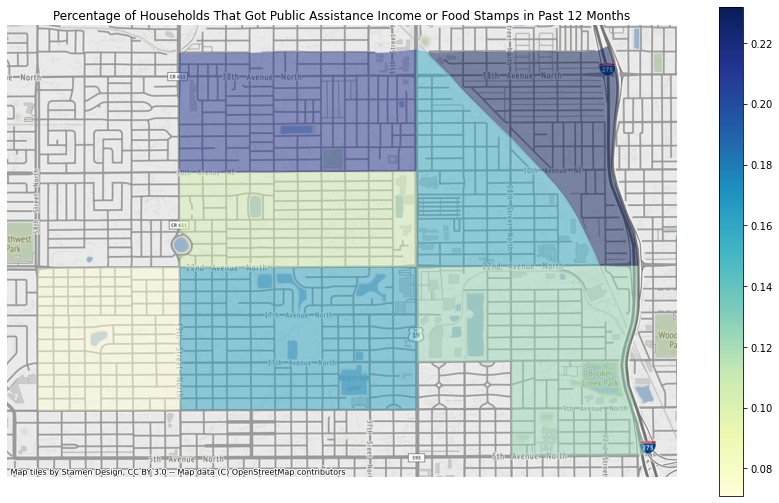

In [14]:
ax = merged.dropna().plot(
    column="percent_assistance",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Percentage of Households That Got Public Assistance Income or Food Stamps in Past 12 Months")

[Text(0.5, 1.0, 'Median Age')]

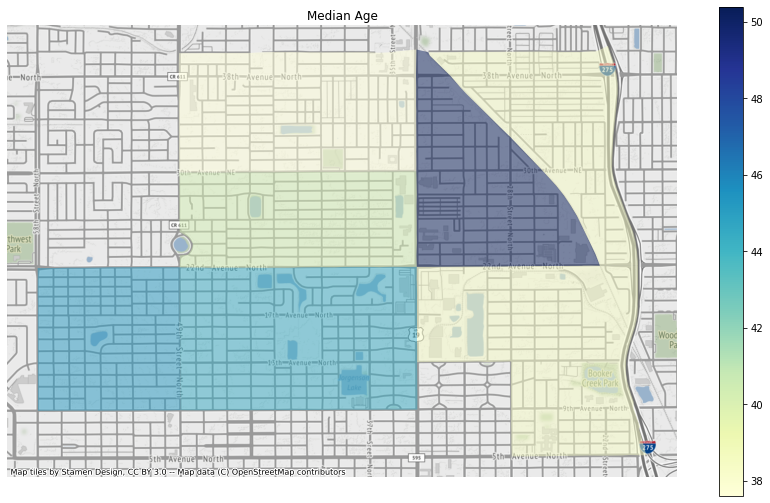

In [16]:
ax = merged.dropna().plot(
    column="median_age_total",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Median Age")